# November hackathon: Costumer Churn Analysis

This is the solution to the November hackathon of BDSD designed by Pietro Marini,
Lorenzo d'Imporzano and Mattia Ravasio. The competition is based on a case of costumer churn analysis in which we want to predict if a costumer if going to exit from a telecommunication contract.

## Data preparation

We started off by importing some necessary libraries and the dataset

In [15]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
data= pd.read_csv('BSDS_November.csv')

After analyzing the dataset and understanding that there are no missing values we decided to extract the dummy variables, whenever possible, from the following categorical variables. We decided to proceed in this way becuase the following variables only presented two different options, for exapmle: 
'Gender' is either 'Female' or 'Male', 'Partner' was either 'Yes' or 'No', 'PhoneService' was either 'Yes' or 'No' and even 'Churn' , our target,  was either 'Yes' or 'No':

In [16]:
data = data.assign(outcome=(data['Churn'] == 'Yes').astype(int))
data = data.assign(genderbool=(data['gender'] == 'Female').astype(int))
data = data.assign(Partnerbool=(data['Partner'] == 'Yes').astype(int))
data = data.assign(PhoneServicebool=(data['PhoneService'] == 'Yes').astype(int))

We then dropped the old categorical columns:

In [17]:
data=data.drop('Churn',axis=1)
data=data.drop('gender',axis=1)
data=data.drop('Partner',axis=1)
data=data.drop('PhoneService',axis=1)

We noticed the presence of an empty string in the column 'TotalCharges' so we decided to substitute it with the mean of the same variable: 

In [18]:
data.TotalCharges=data.TotalCharges.replace(to_replace=' ',value=0.0).astype(float)
mean=data.TotalCharges.mean()
data.TotalCharges=data.TotalCharges.replace(to_replace=' ',value=mean).astype(float)

We finally were able to differenciate and splitted the varibales:

In [31]:
y=data.outcome
bsds_features=['genderbool', 'Partnerbool', 'PhoneServicebool', 'InternetService',
               'OnlineSecurity', 'Contract', 'PaymentMethod', 'MonthlyCharges','TotalCharges'] 
X=data[bsds_features] 
train_X,val_X, train_y, val_y=train_test_split(X,y,train_size=0.9, test_size=0.1)

We dealed with object columns using one-Hot-Encoding:

In [32]:
object_cols=['InternetService','OnlineSecurity', 'Contract', 'PaymentMethod']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[object_cols]))

OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index

num_X_train = train_X.drop(object_cols, axis=1)
num_X_valid = val_X.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X=pd.concat([OH_X_train,OH_X_valid])

## Model Selection

In order to tune the Hyperparameters we runned a GridSearchCV on the different models (we won't report then since they are very costly from a computational point of view). We then perfermed the following procedure using the previous GridSearchCV results to understand which of the models was the best performing using both ROC_AUC and Accuracy:

In [42]:
models = []
models.append(('Logistic Regression', LogisticRegression(C=0.004832930238571752,  max_iter=5000,)))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=17, max_depth=10, max_features='sqrt',min_samples_leaf=4 , random_state = 0)))
models.append(('XGBClassifier', XGBClassifier(max_depth=1,learning_rate=0.15,n_estimators=200)))

acc_results = []
auc_results = []
names = []

col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0

for j in range(len(models)):
    kfold = model_selection.KFold(n_splits=5)

    cv_acc_results = model_selection.cross_val_score(models[j][1], OH_X_train, train_y, cv=kfold, scoring='accuracy')
 
    cv_auc_results = model_selection.cross_val_score(models[j][1], OH_X_train, train_y, cv=kfold, scoring='roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(models[j][0])
    model_results.loc[i] = [models[j][0],
                            round(cv_auc_results.mean()*100, 2),
                            round(cv_auc_results.std()*100, 2),
                            round(cv_acc_results.mean()*100, 2),
                            round(cv_acc_results.std()*100, 2)
                            ]
    print(model_results.loc[i])
    print('\n')

Algorithm        Logistic Regression
ROC AUC Mean                   81.87
ROC AUC STD                     1.03
Accuracy Mean                  78.95
Accuracy STD                    0.63
Name: 0, dtype: object


Algorithm        Kernel SVM
ROC AUC Mean          78.17
ROC AUC STD            1.78
Accuracy Mean         73.34
Accuracy STD           1.17
Name: 0, dtype: object


Algorithm          KNN
ROC AUC Mean     73.94
ROC AUC STD       1.98
Accuracy Mean    75.88
Accuracy STD      0.95
Name: 0, dtype: object


Algorithm        Gaussian NB
ROC AUC Mean           81.74
ROC AUC STD             0.95
Accuracy Mean          72.62
Accuracy STD            0.92
Name: 0, dtype: object


Algorithm        Decision Tree Classifier
ROC AUC Mean                        65.02
ROC AUC STD                          1.98
Accuracy Mean                       72.03
Accuracy STD                         2.19
Name: 0, dtype: object


Algorithm        Random Forest
ROC AUC Mean             82.84
ROC AUC STD       

We can even visualize the box plots:

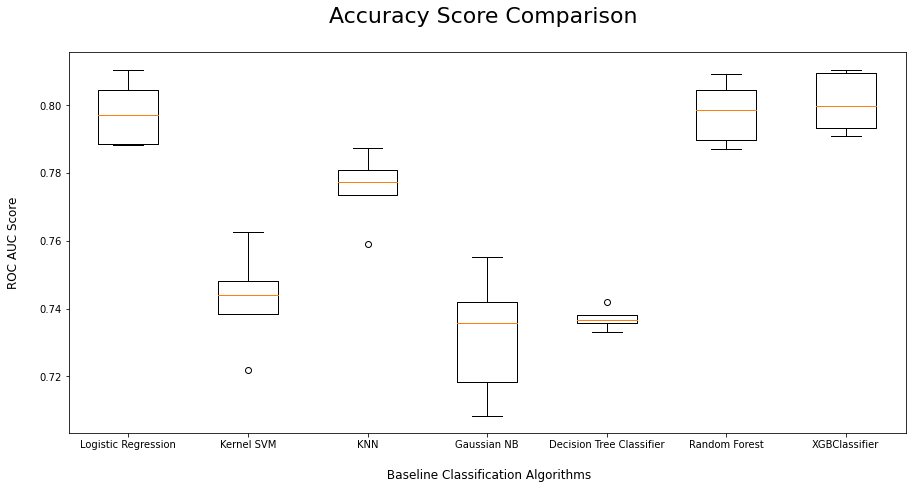

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score\n', horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('\n Baseline Classification Algorithms\n', horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Accuracy Score Comparison \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## Model Improvements

Form this analysis we can see that XGBClassifier is the best performing model, followed by Random Forest and Logistic Regression. We therfore decided to predict with theese three models the churn, with an auxiliary function taking in consideration only the most common results across the different models:

In [40]:
forest_model=RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=17)
forest_model.fit(OH_X_train, train_y)
forest_model_preds=forest_model.predict(OH_X_valid)

logistic_model=LogisticRegression(C=0.004832930238571752, max_iter=5000)
logistic_model.fit(OH_X_train, train_y)
logistic_model_preds=logistic_model.predict(OH_X_valid)

XGB_model=XGBClassifier(max_depth=1,learning_rate=0.15,n_estimators=200)
XGB_model.fit(OH_X_train, train_y)
XGB_model_preds=XGB_model.predict(OH_X_valid)

def most_common_prediction(pred_a, pred_b, pred_c):
    most_predicted = np.zeros(len(pred_a), dtype = int)
    for i in range(len(pred_a)):
        if pred_a[i] + pred_b[i] + pred_c[i] > 1:
            most_predicted[i] = 1
    return most_predicted

final_predict=most_common_prediction(XGB_model_preds, logistic_model_preds,forest_model_preds)

The accuracy score of this procedure will be:

In [41]:
metrics.accuracy_score(val_y, final_predict)

0.8158379373848987

We will now fit the modes on the whole dataset in order to hvae a better accuracy for the competition:

In [43]:
forest_model=RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=17)
forest_model.fit(OH_X,y)

logistic_model=LogisticRegression(C=0.004832930238571752, max_iter=5000)
logistic_model.fit(OH_X,y)

XGB_model=XGBClassifier(max_depth=1,learning_rate=0.15,n_estimators=200)
XGB_model.fit(OH_X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Conclusions

After the improvements we finally have a Machine Learning Algorithm that given the dataset have a 0.8023598820058997 accuracy score when predicting costumer churn.

## Competition Algorithm

This is the final version of the algorithm for the competition, you shall run this algorithm with the competition dataset as imput:

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
data= pd.read_csv('BSDS_November.csv')#This dataset shall be substituted by the competition one

data = data.assign(outcome=(data['Churn'] == 'Yes').astype(int))
data = data.assign(genderbool=(data['gender'] == 'Female').astype(int))
data = data.assign(Partnerbool=(data['Partner'] == 'Yes').astype(int))
data = data.assign(PhoneServicebool=(data['PhoneService'] == 'Yes').astype(int))
data=data.drop('Churn',axis=1)
data=data.drop('gender',axis=1)
data=data.drop('Partner',axis=1)
data=data.drop('PhoneService',axis=1)

data.TotalCharges=data.TotalCharges.replace(to_replace=' ',value=0.0).astype(float)
mean=data.TotalCharges.mean()
data.TotalCharges=data.TotalCharges.replace(to_replace=' ',value=mean).astype(float)

y=data.outcome
bsds_features=['genderbool', 'Partnerbool', 'PhoneServicebool', 'InternetService',
               'OnlineSecurity', 'Contract', 'PaymentMethod', 'MonthlyCharges','TotalCharges'] 
X=data[bsds_features] 

object_cols=['InternetService','OnlineSecurity', 'Contract', 'PaymentMethod']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols = pd.DataFrame(OH_encoder.transform(X[object_cols]))

OH_cols.index = X.index

OH_cols_X = OH_cols.drop(object_cols, axis=1)

forest_model_preds=forest_model.predict(OH_cols_X)

logistic_model_preds=logistic_model.predict(OH_cols_X)

XGB_model_preds=XGB_model.predict(OH_cols_X)

final_predict=most_common_prediction(XGB_model_preds, logistic_model_preds,forest_model_preds)